Thanks to great public kernels (e.g. [Synthetic data for (next?) Instant Gratification](https://www.kaggle.com/mhviraf/synthetic-data-for-next-instant-gratification) and [Quadratic Discriminant Analysis](https://www.kaggle.com/speedwagon/quadratic-discriminant-analysis)), we all know that applying quadratic discriminant analysis to data with the same values of 'wheezy-copper-turtle-magic' is a very promissing way to go in this competition.

QDA has essentially only one hyperparameter, which is 'reg_param', for regularization. What I would like to try here is to see whether using the same 'reg_param', say 0.1 or 0.5, for 512 models is OK. 

To this end, I simply use GridSearchCV in each model.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


### libraries

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print("Libraries were imported.")

Libraries were imported.


### load data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print("Data were loaded.")
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

Data were loaded.


### Parameter tuning on QDA via GridSearchCV

In [4]:
# parameter to be optimized
params = [{'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5]}]

# 512 models
reg_params = np.zeros(512)
for i in range(512):
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = VarianceThreshold(threshold=2).fit_transform(data[cols])

    train3 = data2[:train2.shape[0]]; 
    
    qda = QuadraticDiscriminantAnalysis()
    clf = GridSearchCV(qda, params, cv=4)
    clf.fit(train3, train2['target'])
    
    reg_params[i] = clf.best_params_['reg_param']
    print("Best reg_param for model " + str(i) + " is " + str(reg_params[i]))

Best reg_param for model 0 is 0.5
Best reg_param for model 1 is 0.2
Best reg_param for model 2 is 0.3
Best reg_param for model 3 is 0.2
Best reg_param for model 4 is 0.5
Best reg_param for model 5 is 0.1
Best reg_param for model 6 is 0.1
Best reg_param for model 7 is 0.2
Best reg_param for model 8 is 0.3
Best reg_param for model 9 is 0.5
Best reg_param for model 10 is 0.2
Best reg_param for model 11 is 0.4
Best reg_param for model 12 is 0.1
Best reg_param for model 13 is 0.3
Best reg_param for model 14 is 0.1
Best reg_param for model 15 is 0.4
Best reg_param for model 16 is 0.3
Best reg_param for model 17 is 0.2
Best reg_param for model 18 is 0.2
Best reg_param for model 19 is 0.5
Best reg_param for model 20 is 0.1
Best reg_param for model 21 is 0.4
Best reg_param for model 22 is 0.4
Best reg_param for model 23 is 0.1
Best reg_param for model 24 is 0.5
Best reg_param for model 25 is 0.4
Best reg_param for model 26 is 0.1
Best reg_param for model 27 is 0.4
Best reg_param for model 28 is

<Figure size 432x288 with 0 Axes>

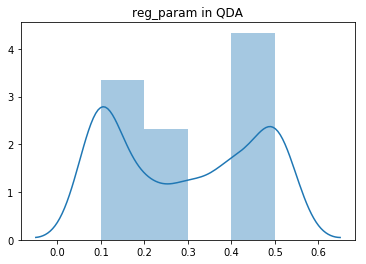

<Figure size 432x288 with 0 Axes>

In [5]:
sns.distplot(reg_params)
plt.title("reg_param in QDA")
plt.figure()

In [6]:
def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [7]:

from sklearn.covariance import GraphicalLasso
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

In [8]:
cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
        gm.fit(np.concatenate([train3,test3],axis = 0))
        oof[idx1[test_index]] = gm.predict_proba(train3[test_index,:])[:,0]
        preds[idx2] += gm.predict_proba(test3)[:,0] / skf.n_splits

        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('QDA scores CV =',round(auc,5))

100%|██████████| 512/512 [07:09<00:00,  1.22it/s]

QDA scores CV = 0.96749


In [9]:
test['target'] = preds
for k in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    # ADD PSEUDO LABELED DATA
    test2p = test2[ (test2['target']<=0.01) | (test2['target']>=0.99) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train3) ] # ignore pseudo in oof
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        preds[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits
       
    #if k%64==0: print(k)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('Pseudo Labeled QDA scores CV =',round(auc,5))


Pseudo Labeled QDA scores CV = 0.96937


In [10]:
from tqdm import tqdm_notebook
from sklearn.pipeline import Pipeline
for itr in range(10):
    test['target'] = preds
    test.loc[test['target'] > 0.94, 'target'] = 1
    test.loc[test['target'] < 0.06, 'target'] = 0
    usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
    new_train = pd.concat([train, usefull_test]).reset_index(drop=True)
    print(usefull_test.shape[0], "Test Records added for iteration : ", itr)
    new_train.loc[oof > 0.98, 'target'] = 1
    new_train.loc[oof < 0.02, 'target'] = 0
    oof2 = np.zeros(len(train))
    preds = np.zeros(len(test))
    for i in tqdm_notebook(range(512)):

        train2 = new_train[new_train['wheezy-copper-turtle-magic']==i]
        test2 = test[test['wheezy-copper-turtle-magic']==i]
        idx1 = train[train['wheezy-copper-turtle-magic']==i].index
        idx2 = test2.index
        train2.reset_index(drop=True,inplace=True)

        data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
        pipe = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
        data2 = pipe.fit_transform(data[cols])
        train3 = data2[:train2.shape[0]]
        test3 = data2[train2.shape[0]:]

        skf = StratifiedKFold(n_splits=11, random_state=42)
        for train_index, test_index in skf.split(train2, train2['target']):
            oof_test_index = [t for t in test_index if t < len(idx1)]
            
            clf = QuadraticDiscriminantAnalysis(0.5)
            clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof2[idx1[oof_test_index]] = clf.predict_proba(train3[oof_test_index,:])[:,1]
            preds[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
    auc = roc_auc_score(train['target'], oof2)
    print(f'AUC: {auc:.5}')

126614 Test Records added for iteration :  0



AUC: 0.97039
124559 Test Records added for iteration :  1



AUC: 0.97025
124464 Test Records added for iteration :  2



AUC: 0.97022
124455 Test Records added for iteration :  3



AUC: 0.97021
124452 Test Records added for iteration :  4



AUC: 0.97021
124452 Test Records added for iteration :  5



AUC: 0.97021
124452 Test Records added for iteration :  6



AUC: 0.97021
124452 Test Records added for iteration :  7



AUC: 0.97021
124452 Test Records added for iteration :  8



AUC: 0.97021
124452 Test Records added for iteration :  9



AUC: 0.97021


In [11]:

sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)